# Check Points
The selection of tokens was checked by:
- a glance at the most/least frequent tokens
- hitograms
- Zipf's law

# Setup

In [1]:
from collections import Counter

In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
import pandas as pd

In [4]:
import math

# Analysis

## Morphological Analysis

In [5]:
def my_morphol(filename):
	sentences = []
	sentence = []
	previous_line = ''
	MID = -1
	with open(filename, mode='r') as f:
		for line in f:
			# skip header
			# 文頭 or 文中
			if line != 'EOS\n':
				fields = line.split('\t')
				attr = fields[1].split(',')
				# the beginning/middle of a sentence
				if previous_line == '':
					continue
				# a MID line
				elif fields[0] == 'MID':
					continue
				# the beginning of a sentence
				elif previous_line == 'EOS\n' and attr[1] == '数':
					MID = int(fields[0])
					sentence.append(MID)
				# the middle of a sentece
				else:
					morph = {'surface': fields[0], 'base': attr[6], 'pos': attr[0], 'pos1': attr[1]}
					sentence.append(morph)
			# EOS
			else:
				if MID > 0 and len(sentence) > 0:
					sentences.append(sentence)
					sentence = []
					MID = -1
				elif MID > 0 and len(sentence) == 0:
					sentences.append([])
					sentence = []
					MID = -1

			previous_line = line

	return sentences

In [6]:
# SELF
filename = './output01_self.txt.mecab'
sentences_self = my_morphol(filename)

In [7]:
# TARGET
filename = './output01_target.txt.mecab'
sentences_target = my_morphol(filename)

## Tokenization

In [9]:
def my_tokenization(sentences):
	sentences_token = []
	sentence_token = []
	for sentence in sentences:
		# sentence[0] = MID
		sentence_token.append(sentence[0])

		for morph in sentence[1:]:
			# POS according to https://www.gavo.t.u-tokyo.ac.jp/~mine/japanese/nlp+slp/NAIST-JDIC_manual.pdf
			# Words for Traits
			if morph['pos'] == '形容詞' and morph['pos1'] == '自立':
				sentence_token.append(morph['base'])
			elif morph['pos'] == '名詞' and morph['pos1'] == '形容動詞語幹':
				if morph['base'] != '*\n':
					sentence_token.append(morph['base'])
			elif morph['pos'] == '名詞' and morph['pos1'] == 'ナイ形容詞語幹':
				if morph['base'] != '*\n':
					sentence_token.append(morph['base'])

			# Words for Behaviors
			elif morph['pos'] == '動詞' and morph['pos1'] == '自立':
				sentence_token.append(morph['base'])
			elif morph['pos'] == '名詞' and morph['pos1'] == 'サ変接続':
				if morph['base'] != '*\n':	# e.g, {'surface': '､', 'base': '*\n', 'pos': '名詞', 'pos1': 'サ変接続'}
					sentence_token.append(morph['base'])

			# Words for Stereotype etc
			elif morph['pos'] == '名詞' and morph['pos1'] == '一般':
				if morph['base'] != '*\n':	# e.g., {'surface': 'キャパオーバー', 'base': '*\n', 'pos': '名詞', 'pos1': '一般'},
					sentence_token.append(morph['base'])
			elif morph['pos'] == '名詞' and morph['pos1'] == '固有名詞':
				if morph['base'] != '*\n':	# {'surface': 'k', 'base': '*\n', 'pos': '名詞', 'pos1': '固有名詞'}
					sentence_token.append(morph['base'])
			elif morph['pos'] == '名詞' and morph['pos1'] == '代名詞':
				if morph['base'] != '*\n':
					sentence_token.append(morph['base'])

		sentences_token.append(sentence_token)
		sentence_token = []

	return sentences_token

In [10]:
# SELF
sentences_token_self = my_tokenization(sentences_self)

In [11]:
# TARGET
sentences_token_target = my_tokenization(sentences_target)

# The most/least frequent tokens

In [12]:
# Expanding multidimensional arrays
word_list_self = sum(sentences_token_self,[])
word_list_target = sum(sentences_token_target,[])
# Count tokens
word_count_all = Counter(word_list_self + word_list_target).most_common()
word_count_self = Counter(word_list_self).most_common()
word_count_target = Counter(word_list_target).most_common()

## Self + Target

In [13]:
word_count_df_all = pd.DataFrame([w[1] for w in word_count_all],
				index = [w[0] for w in word_count_all],
				columns = ['ALL'])
word_count_df_all.head(10)

,ALL
する,372
人,164
ある,145
思う,133
自分,98
ない,96
行動,72
なる,60
責任,60
考える,54


## Self

In [14]:
word_count_df_self = pd.DataFrame([w[1] for w in word_count_self],
				index = [w[0] for w in word_count_self],
				columns = ['SELF'])
word_count_df_self.head(10)

,SELF
する,195
人,87
ある,76
思う,68
自分,54
ない,50
なる,43
行動,36
責任,33
やる,30


## Target

In [15]:
word_count_df_target = pd.DataFrame([w[1] for w in word_count_target],
				index = [w[0] for w in word_count_target],
				columns = ['TARGET'])
word_count_df_target.head(10)

,TARGET
する,177
人,77
ある,69
思う,65
ない,46
自分,44
行動,36
良い,31
責任,27
言う,26


In [16]:
# Crreate a DataFrame
word_count_df = pd.merge(word_count_df_all, word_count_df_self, how='outer', left_index=True, right_index=True)
word_count_df = pd.merge(word_count_df, word_count_df_target, how='outer', left_index=True, right_index=True)
word_count_df.sort_values(by=['ALL'], ascending=False).head(10)

,ALL,SELF,TARGET
する,372,195.0,177.0
人,164,87.0,77.0
ある,145,76.0,69.0
思う,133,68.0,65.0
自分,98,54.0,44.0
ない,96,50.0,46.0
行動,72,36.0,36.0
責任,60,33.0,27.0
なる,60,43.0,17.0
考える,54,29.0,25.0


In [17]:
word_count_df

,ALL,SELF,TARGET
1,2,1.0,1.0
2,2,1.0,1.0
3,2,1.0,1.0
4,2,1.0,1.0
5,2,1.0,1.0
...,...,...,...
高校生,1,1.0,NaN
鳥,1,1.0,NaN
鹿,1,NaN,1.0
黒白,1,NaN,1.0


# Histograms

## The frequencies of tokens and thier frequency (出現頻度 vs. 単語の種類数)

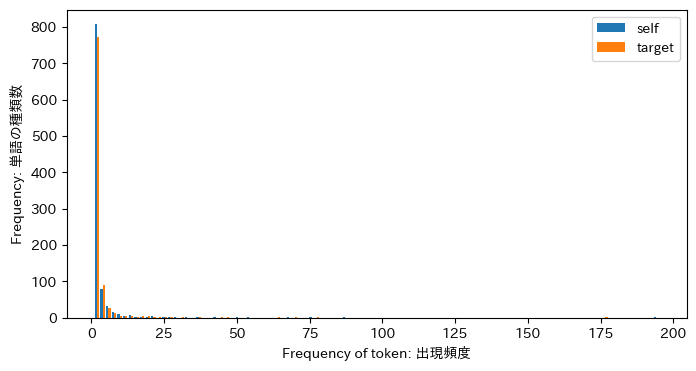

In [19]:
plt.figure(figsize=(8, 4))
plt.hist([word_count_df.SELF, word_count_df.TARGET], bins=100, label=['self', 'target'])
plt.xlabel('Frequency of token: 出現頻度')
plt.ylabel('Frequency: 単語の種類数')
plt.legend()
plt.show()

## The most frequent tokens (Top N)

<Figure size 800x400 with 0 Axes>

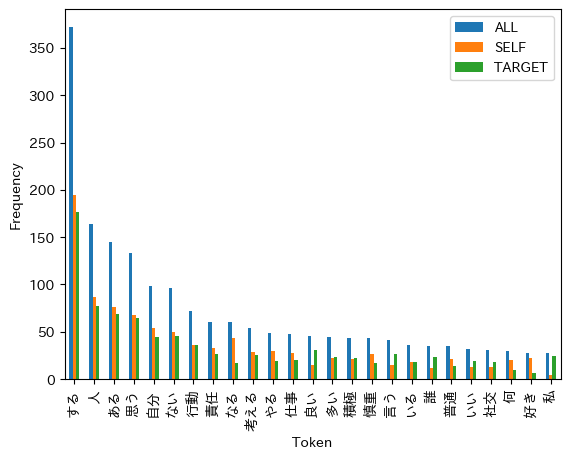

In [21]:
# TopN
topn = 25
plt.figure(figsize=(8, 4))
word_count_df.sort_values(by="ALL", ascending=False)[:topn].plot(y=["ALL", "SELF", "TARGET"], kind="bar", use_index=True)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# The Zipf's Law

In [22]:
word_freq_all = word_count_df.sort_values(by='ALL', ascending=False).ALL.values
word_freq_self = word_count_df.sort_values(by='SELF', ascending=False).SELF.values
word_freq_target = word_count_df.sort_values(by='TARGET', ascending=False).TARGET.values

In [23]:
ranks = list(range(1, len(word_freq_all) + 1))

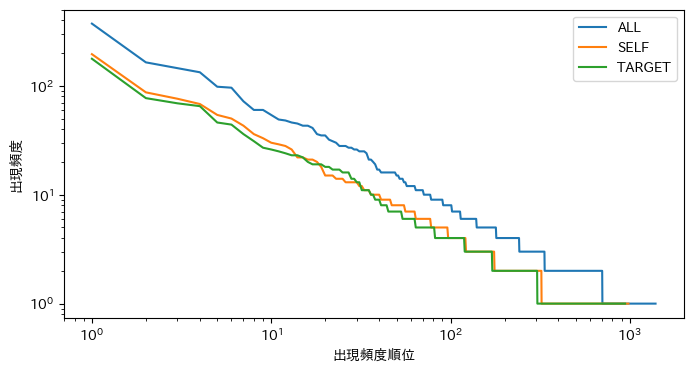

In [24]:
plt.figure(figsize=(8, 4))
plt.loglog(ranks, word_freq_all,
	ranks, word_freq_self,
	ranks, word_freq_target)
plt.xlabel('出現頻度順位')
plt.ylabel('出現頻度')
plt.legend(["ALL", "SELF", "TARGET"])
plt.show()